In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    multilabel_confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import warnings
from transformers import BertTokenizer, BertModel
warnings.filterwarnings("ignore")

## Carga de datos

En esta sección se cargan los datos de la competencia y se preparan dos nuevas columnas para facilitar el trabajo posterior. La primera, `labels`, convierte los valores de la columna group en listas; por ejemplo, el texto neurological|hepatorenal pasa a ser ['neurological', 'hepatorenal'], lo que simplifica el proceso de clasificación multietiqueta. La segunda columna, `text`, combina el contenido de title y abstract en un solo texto, pensado para generar los embeddings de cada registro.

In [ ]:
# Cargar CSV 
df = pd.read_csv("../data/dataset.csv", sep=";")

# Crear columna de etiquetas como listas
df['labels'] = df['group'].str.split('|')

# Lista de todas las clases únicas
all_labels = sorted(set(label for labels in df['labels'] for label in labels))
print(all_labels)

df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

## Construción embbeding medio

Siguiendo la misma lógica del proceso con el modelo de gemini_linearSVC, en esta implementación los embeddings se generan de manera local utilizando el modelo BERT en lugar de depender de una API externa. Para ello, se carga el tokenizador y el modelo preentrenado **bert-base-uncased**, y el modelo se mueve a GPU si está disponible para optimizar el rendimiento.

Se implementa una función que recibe como parámetro la columna `text` de cada registro. Este texto se tokeniza y se procesa con BERT, obteniendo representaciones vectoriales para cada token. A continuación, se calcula el mean embedding, promediando los vectores de todos los tokens para obtener una representación compacta de cada registro. Los embeddings resultantes se almacenan en una nueva columna llamada **embedding**.

Este enfoque elimina la dependencia de servicios externos, permitiendo un procesamiento más rápido y económico. Además, aunque los mean embeddings son de nivel intermedio, resultan adecuados para tareas de clasificación y análisis de texto sin requerir modelos más costosos o complejos.

In [20]:
#Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

#Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
#Tokenizar ejemplo
text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt").to(device)

In [22]:
#Obtener SOLO embeddings de tokens (sin positional encoding)
with torch.no_grad():
    token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])

In [23]:
# Eliminar dimensión batch → (n_tokens, d_model)
token_matrix = token_embeddings.squeeze(0)

# Calcular embedding promedio en GPU
mean_embedding = token_matrix.mean(dim=0)   # (d_model,)
print("Mean embedding shape:", mean_embedding.shape)

Mean embedding shape: torch.Size([768])


In [24]:
mean_embedding.shape, mean_embedding.dtype

(torch.Size([768]), torch.float32)

In [27]:
# Supongamos que tu DataFrame se llama df
# Filtramos solo las filas con los grupos que nos interesan


# Definir X (texto) e y (labels)
X = df["text"].values
y = df["labels"].values

print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)
print("Clases presentes:", all_labels)


Tamaño de X: (3565,)
Tamaño de y: (3565,)
Clases presentes: ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


In [28]:
def get_mean_embedding(text):
    # Tokenización y envío a GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        # SOLO token embeddings, sin positional encoding
        token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])
        token_matrix = token_embeddings.squeeze(0)       # (n_tokens, d_model)
        mean_embedding = token_matrix.mean(dim=0)        # (d_model,)
    return mean_embedding.cpu().numpy()  # traer a CPU como numpy

In [ ]:

# Construir X (mean embedding)
X = np.vstack([get_mean_embedding(text) for text in df["text"].values])
print("Shape de X:", X.shape)  # (num_samples, d_model=768)

# Construir y (one-hot encoding)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])

print("Shape de y:", y.shape)
print("Clases:", all_labels)

Shape de X: (3565, 768)
Shape de y: (3565, 4)
Clases: ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


## Model

Una vez generados los embeddings, estos se emplean para entrenar modelos de clasificación. Tras realizar diversas pruebas, los algoritmos que obtuvieron mejores resultados fueron **LogisticRegression** y **LinearSVC**.

Para manejar el problema de clasificación multietiqueta, se utilizó **MultiLabelBinarizer**, una herramienta que transforma las etiquetas de cada texto en una representación binaria (matriz de ceros y unos), donde cada columna corresponde a una clase. Esta transformación permite que los modelos trabajen de manera eficiente con múltiples etiquetas por registro.

Posteriormente, se aplicó **OneVsRestClassifier**, que entrena un clasificador independiente por cada clase. En este esquema, cada clasificador funciona como un modelo binario encargado de predecir si un texto pertenece o no a una categoría específica.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# LinearSVC es inherentemente binario, por lo que necesita el wrapper OneVsRest
classifier = OneVsRestClassifier(
    LinearSVC(
        dual=True,
        random_state=42,
        max_iter=2000,
        C=16,
        tol=0.2,
        multi_class="crammer_singer",
    )
)
# Entrenar el modelo
classifier.fit(X_train, y_train)
# Hacer predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test)

In [ ]:
# Usar un clasificador que soporte multietiqueta, como OneVsRest con LogisticRegression
# OneVsRest entrena un clasificador binario para cada clase, lo cual es ideal para resolver el problema
classifier = OneVsRestClassifier(
    LogisticRegression(solver='newton-cholesky', class_weight="balanced", C=400,tol=1)
)

# Entrenar el modelo
classifier.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test)

## Evaluacion de resultado

Bajo el enfoque de generación de embeddings con **BERT**, se observó que el **accuracy** disminuyó ligeramente en comparación con los embeddings generados por el modelo de **Gemini**, pasando de un **68%** a un **65%**. Sin embargo, el **f1_score ponderado** se mantuvo bastante similar (**0.8337** contra **0.8502**), lo que indica que el desempeño en términos de equilibrio entre precisión y cobertura de las etiquetas no se vio afectado de manera significativa.  

Además, este enfoque ofrece una **gran mejora en la velocidad de generación de embeddings**, ya que el proceso se ejecuta de forma local sin depender de servicios externos.  

Con este nuevo esquema, el modelo que obtuvo los **mejores resultados** fue **LogisticRegression**, superando el desempeño de **LinearSVC** en esta configuración. Esto sugiere que, aunque el cambio de embeddings afecta ligeramente la exactitud global, el modelo logra mantener un rendimiento estable y competitivo en tareas de clasificación multietiqueta.  




In [ ]:
predict=classifier.predict(X_train)
accuracy=accuracy_score(y_train,predict)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en train")

el modelo presenta un accuracy de 0.7908% en train


In [40]:
accuracy=accuracy_score(y_pred,y_test)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en test")

el modelo presenta un accuracy de 0.6551% en test


In [41]:
# Calcular F1-Score Ponderado (métrica principal del challenge)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Métrica Principal - F1 Score Ponderado (Weighted): {weighted_f1:.4f}\n")

# Reporte de clasificación completo (muestra métricas por cada clase)
print("Reporte de Clasificación Detallado (por clase):")
# Usamos `target_names` para que el reporte muestre los nombres de las clases
print(classification_report(y_test, y_pred, target_names=all_labels))


Métrica Principal - F1 Score Ponderado (Weighted): 0.8337

Reporte de Clasificación Detallado (por clase):
                precision    recall  f1-score   support

cardiovascular       0.86      0.84      0.85       375
   hepatorenal       0.86      0.79      0.83       346
  neurological       0.86      0.85      0.85       514
   oncological       0.73      0.80      0.76       204

     micro avg       0.84      0.83      0.83      1439
     macro avg       0.83      0.82      0.82      1439
  weighted avg       0.84      0.83      0.83      1439
   samples avg       0.88      0.88      0.85      1439



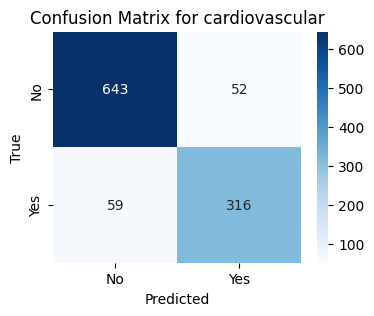

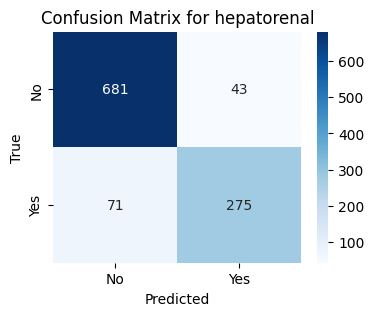

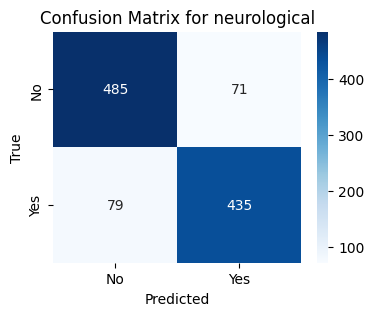

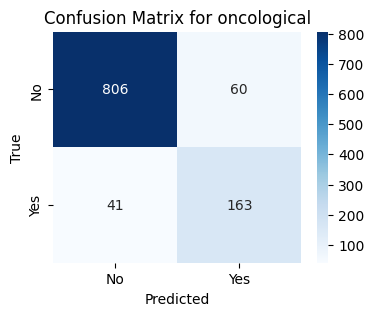

In [18]:
mcm = multilabel_confusion_matrix(y_test,y_pred)
for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

In [ ]:
y_pred=classifier.predict(X)
#Convertir predicciones binarias a tuplas de texto
predicted_labels_tuples = mlb.inverse_transform(y_pred)

#Unir las tuplas en un solo string separado por '|'
predicted_labels_strings = ["|".join(labels) for labels in predicted_labels_tuples]

#Crear el DataFrame de salida final
output_df = pd.DataFrame(predicted_labels_strings)
output_df = df[["title", "abstract","group"]].copy()
output_df["group_predicted"] = predicted_labels_strings

In [54]:
output_df["group_predicted"].value_counts()

group_predicted
neurological                               1493
cardiovascular                              766
hepatorenal                                 518
oncological                                 209
cardiovascular|neurological                 197
hepatorenal|neurological                    106
                                             97
neurological|oncological                     80
cardiovascular|hepatorenal                   49
hepatorenal|oncological                      29
cardiovascular|oncological                   17
hepatorenal|neurological|oncological          3
cardiovascular|hepatorenal|neurological       1
Name: count, dtype: int64

## Save model

In [ ]:
import pickle

# Guardar en un archivo .pkl
with open("linearsvc_model.pkl", "wb") as f:
    pickle.dump(classifier, f)
